## Introduction and Description of Data


Gyms have a difficulty with customer churn, since it is not always clear if a customer is no longer a customer - if he or her quit. Sometimes the customer might take an affirmative action to suspend his or her membership (e.g. by shutting down their accounts or not renewing their contract once it runs out). However, sometimes it's not that clear cut. Sometimes they just disappear - poof! 

In this analysis I will analyze a sample of the gym chain Model Fitness's digitized customer profiles for the purpose of finding a customer retention strategy for the chain. 

In this analysis I will take the following steps: 
 - Overview the data in the dataframe, to check if there are any missing values or if the data shoud be preprocessed before analysis;
 - Explore the data's distribution, overall and by churn/stay groups - whether in the preceding month a customer churned (left) or stayed;
 - Analyze the correlation between the features in the dataframe with the target feature - churn; 
 - Finally, I will build a model to help predict customer churn, test and train it. I will evaluate the accuracy, precision, recall and f1 matrics for all models using the validation data in order to compare the models and determine which model performed best;
 - Then, I will pick a final model and examine the importance of the features;
 - I will Plot a dendrogram displaying user clusters. Then I will, train the clustering model with the K-means algorithm and predict customer clusters and plot graphs to examine the distributions of features for the clusters;
 - Last but not least, I will calculate the churn rate for each cluster. 


## Description of the Data

In this analysis, I am working with one dataframe containing the following columns and information:

User data for the preceding month
 - 'Churn' — the fact of churn for the month in question;
 - 'gender';
 - 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located;
 - 'Partner' — whether the user is an employee of a partner company (partner companies whose employees get discounts - in those cases the gym stores information on customers' employers);
 - 'Promo_friends' — whether the user originally signed up through a "bring a friend" offer (using a promo code for their first membership);
 - 'Phone' — whether the user provided their phone number;
 - 'Age';
 - 'Lifetime' — the time (in months) since the customer first came to the gym.
 
Data from the log of visits and purchases and data on current membership status

 - 'Contract_period' — 1 month, 3 months, 6 months, or 1 year;
 - 'Month_to_end_contract' — the months remaining until the contract expires;
 - 'Group_visits' — whether the user takes part in group sessions;
 - 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime;
 - 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month;
 - 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


## Loading and Initial Exploration of the Data

First, I will load necessary libraries and read the dataframe. Then, I will perform an initial exploration of the data. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score


In [3]:
try:
    gym_data = pd.read_csv('/Users/doronerlich/Desktop/Code ME/Course Project 9/gym_churn_us.csv')
except:
    gym_data = pd.read_csv('/datasets/gym_churn_us.csv')

In [4]:
gym_data.info('deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

As we can see, it doesn't seem like there are any missing values in the dataframe or that there is any need to change incorrect data types. 

In [5]:
gym_data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Also, we should note that the STD (Standard Deviation) of each column doesn't stray far from the mean, which means that there aren't any notable anomalies or outliers in the data. This also point to the wide distribution of the values. 

In [6]:
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Last but no least, I printed a sample of the dataframe. Everything seems intact. 

### Summary

From the initial exploration of the data, it is quite likely that there are no missing values in the data (there are 4,000 values in all 14 columns).

It should also be noted that from reviewing the means and the STD's of the values of the dataframe's columns, there aren't any notable anomalies or outliers in the data.


## Preprocessing of the Data

In [7]:
gym_data.columns= gym_data.columns.str.lower()

In [8]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Above, I turned all the column names to lower case, for easier and consistent use. Other than that, it doesn't seem like there any other preprocessing needed since the data types are intact and there are no missing values. 

## Exploratory Data Analysis

### Customer Features for Churn/Stay Customer

In [9]:
gym_data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Above, I created a table showing the means of two groups of customers, those how churned and those who stayed, per feature. We should note that:
 - There is no notable affect of a customer's gender, or whether a customer provided a phone number, on the fact he or she churned or not;
 - Customer leaving near the gym are more likely to stay, but the difference is insignificant; 
 - If the customer is an employee of a partner company, he or she is more likely to stay - same for customers who joined via a person they know;
 - Commitment breeds staying - customers who frequently attend classes, are more likely to stay (more so with group sessions) - As do customers who invest additional charges; 
 - Customers who are slightly older are more likely to stay; 
 - Customers tend not to churn the further they are from the end of their contract and the longer they are customers. 

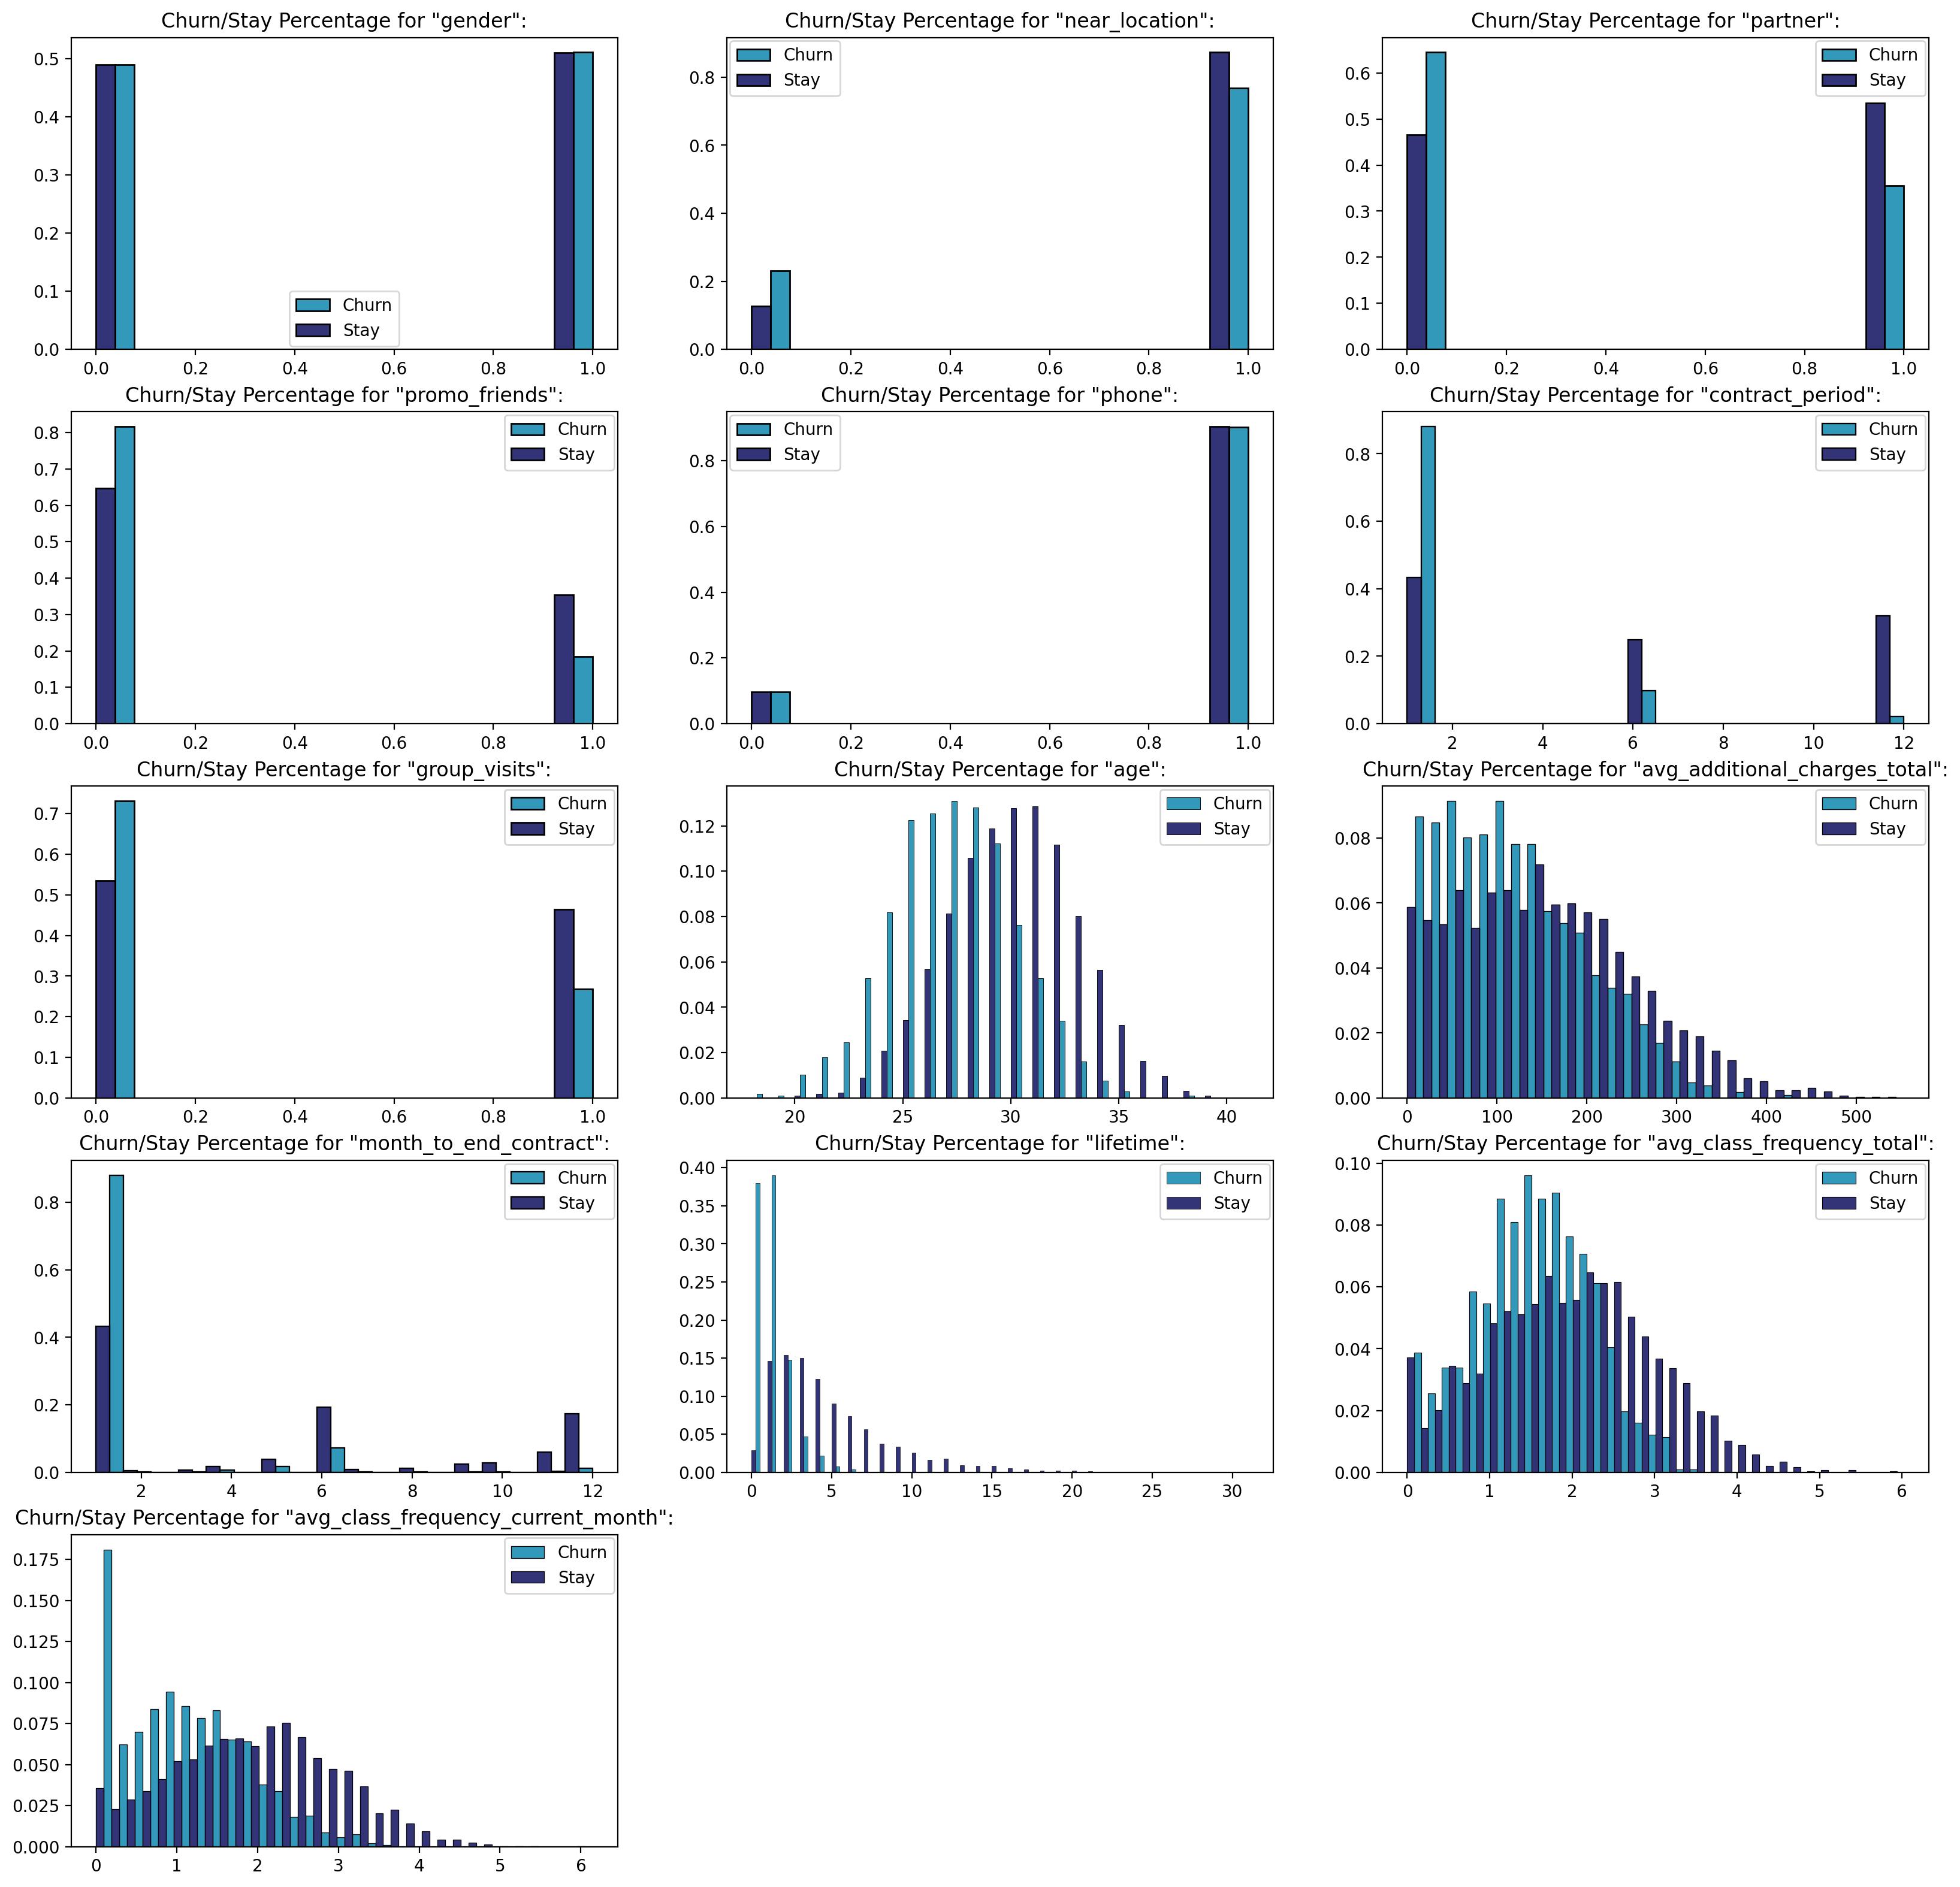

In [10]:
row, column = 5,3
x_i, y_i = 0, 0
fig, axes = plt.subplots(figsize=(20, 20), dpi=200)
columns = ["gender", "near_location", "partner", "promo_friends", "phone", "contract_period", 
           "group_visits", "age", "avg_additional_charges_total", "month_to_end_contract", "lifetime", 
           "avg_class_frequency_total", "avg_class_frequency_current_month"]
for col in columns:
    ax = plt.subplot2grid((row, column), (x_i, y_i))
    sns.set_palette('ocean', 2)
    ax = sns.histplot(data=gym_data, x=col, hue='churn', stat="probability", common_norm=False, multiple="dodge", alpha=0.8)
    plt.legend(loc='best', borderaxespad=0.2, labels=["Churn","Stay"])
    ax.set(xlabel=None, ylabel=None, title='Churn/Stay Percentage for "{}":'.format(col))
    y_i += 1
    if y_i == column: 
        x_i += 1
        y_i = 0


Scanning the percentage of customers who churned vs. those who stayed in each feature, we can see the same trends noted above:
 - Customers who live near the location of the gym have a high stay percentage;
 - Employees of partner companies also have a higher stay percentage;
 - Most customers didn't become customers via someone they knew, but if they did - they are more likely to stay;
 - Most customers have short term contracts but, the longer the contract period the better;
 - Most customers don't attend group sessions, but if they do - there's a higher percentage of them staying;
 - Older customers have a higher stay percentage than younger ones;
 - Customers who invest additional funds in their membership have a high stay percentage;
 - The more months customers have left, the higher the stay percentage, as do the longer the are customers - loyalty plays its part;
 - Customers who are active participants have higher stay percentage. 
 
(note that in my original notebook stat was "precent" but it didn't work in the platform notebook)


### Distribution of None Binary Features

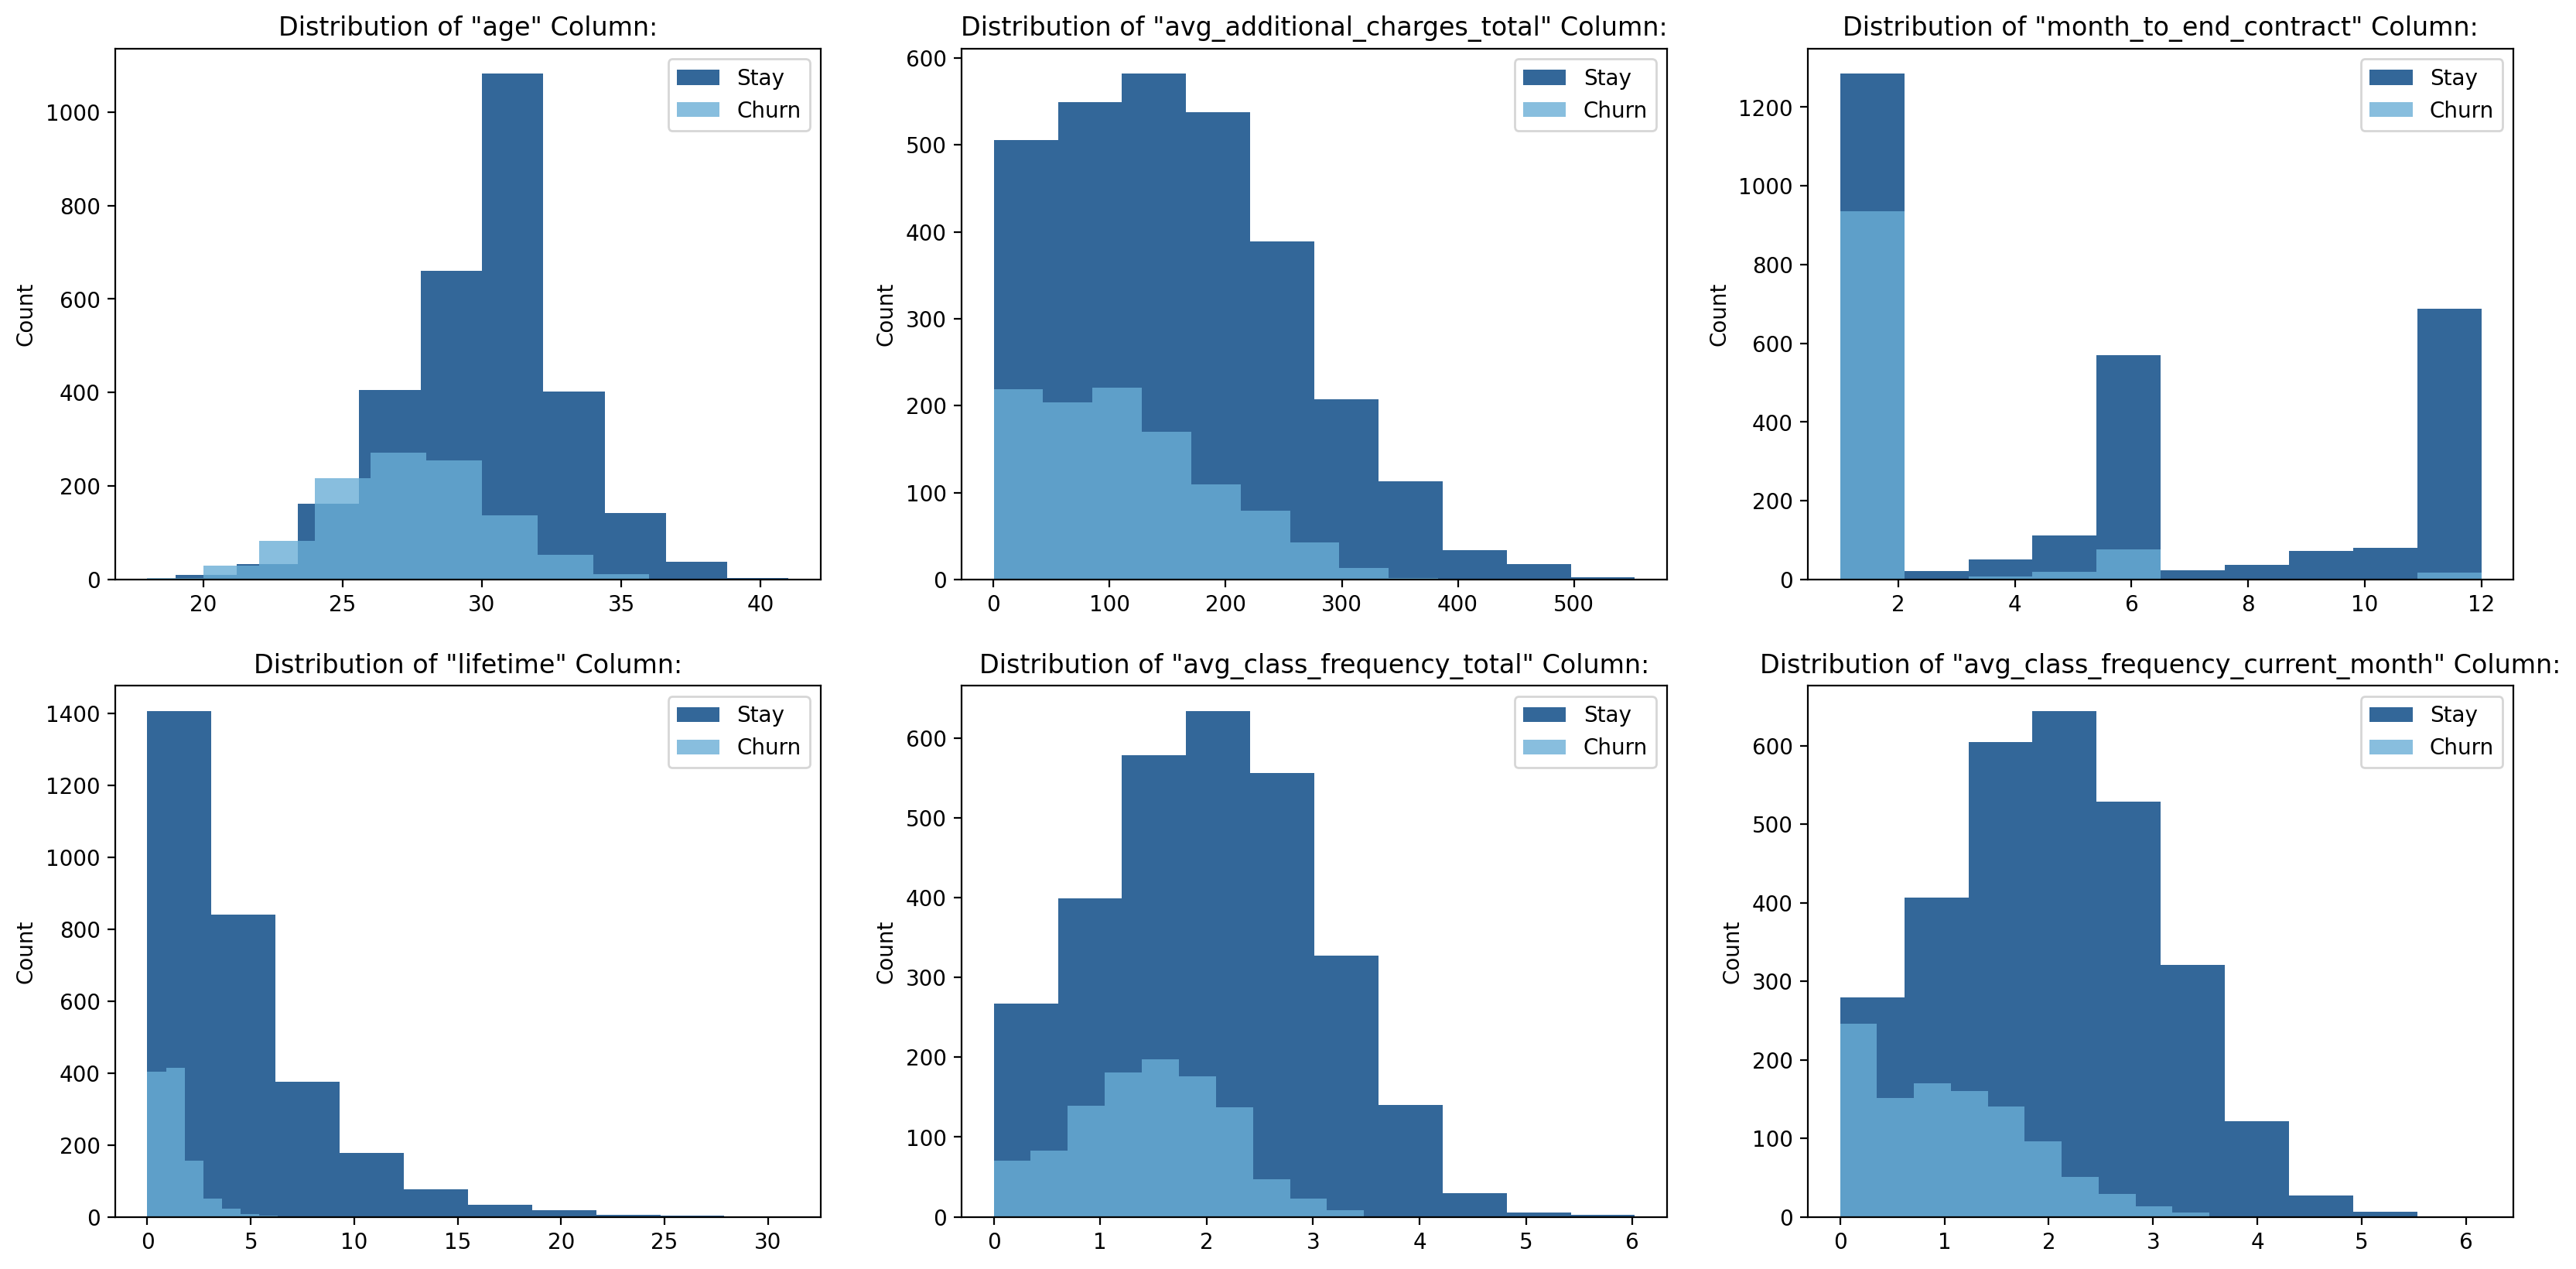

In [11]:
row, column = 2,3
x_i, y_i = 0, 0
fig, axes = plt.subplots(figsize=(20, 10), dpi=200)
columns = gym_data[["age", "avg_additional_charges_total", "month_to_end_contract", "lifetime", 
           "avg_class_frequency_total", "avg_class_frequency_current_month"]]
for col in columns:
    ax = plt.subplot2grid((row, column), (x_i, y_i))
    ax = plt.hist(gym_data.query('churn == 0')[col], bins=10, alpha = 0.8, edgecolor = "none", color=sns.color_palette('ocean', 1))
    ax = plt.hist(gym_data.query('churn == 1')[col], bins=10, alpha = 0.8, edgecolor = "none", color=sns.color_palette('Blues', 1))
    plt.ylabel('Count')
    plt.title('Distribution of "{}" Column:'.format(col))
    plt.legend(['Stay', 'Churn'])
    y_i += 1
    if y_i == column: 
        x_i += 1
        y_i = 0

Above, scanning the distribution of the values across the none binary features (and the "contract_period" that has three options - 1 month, 6 months or 12 months) - we can note, again, that there aren't any notable anomalies or outliers in the data.

### Features' Correlation

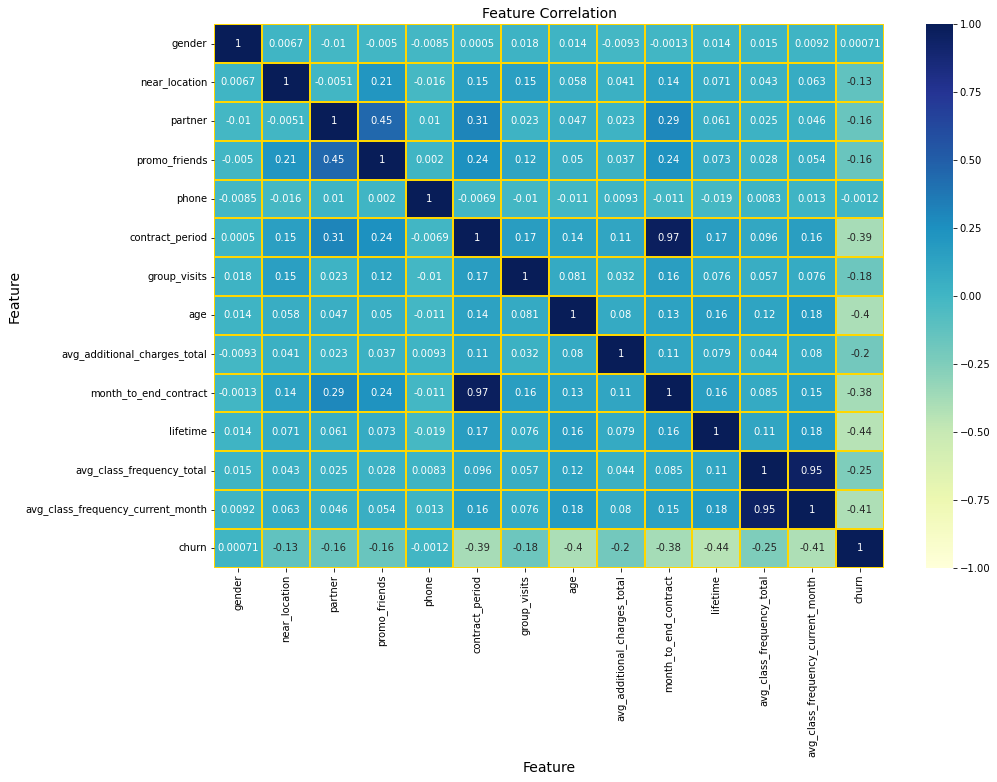

In [12]:
plt.figure(figsize=(15, 10))
plt.title('Feature Correlation', size=14)
sns.heatmap(gym_data.corr(),annot=True,linewidths=.1,linecolor='gold',cmap="YlGnBu", vmin=-1, vmax=1)
plt.xlabel("Feature", size=14) 
plt.ylabel("Feature", size=14) 
plt.show()

As is visible by the correlation matrix above, the highest correlation is between customers' avg_class_frequency_total activity and their avg_class_frequency_current_month activity. 

In regards with the target feature, whether customers churn or stay, the highest correlation is with the following features:
 - lifetime;
 - avg_class_frequency_current_month;
 - age;
 - contract_period;
 - month_to_end_contract.
 
As expected, there is virtually no correlation between whether customers churn or not and their gender, phone number and group sessions.
 
Recent activity has more correlation with customer churn than with overall activity, and the correlation is not strong in regards to location, customers who are employees of partner companies or if they joined via someone they know or their additional charges. 

## Building a Model to Predict Customer Churn

In the following section, I will build a binary classification model to predict customer churn. 

In [13]:
X = gym_data.drop('churn', axis = 1)
y = gym_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


I divided gym_data into features (X) and a target variable (y) and then into train and test sets. Next, I will build a function called "matrics_predictions" to calculate and print each model's metrics.

In [14]:
def matrics_predictions(y_true, y_pred):
    print("Accuracy: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1: {:.2f}"
                .format(accuracy_score(y_true, y_pred), precision_score (y_true, y_pred), 
                       recall_score (y_true, y_pred), f1_score (y_true, y_pred)))

In [15]:
models= [LogisticRegression(random_state= 0), DecisionTreeClassifier(random_state= 0),
         RandomForestClassifier(random_state= 0), GradientBoostingClassifier(random_state= 0)]

for m in models:
    print('{} Model:'.format(m))
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    matrics_predictions(y_test, y_pred)

LogisticRegression(random_state=0) Model:
Accuracy: 0.91 
Precision: 0.82 
Recall: 0.80 
F1: 0.81
DecisionTreeClassifier(random_state=0) Model:
Accuracy: 0.90 
Precision: 0.79 
Recall: 0.80 
F1: 0.80
RandomForestClassifier(random_state=0) Model:
Accuracy: 0.92 
Precision: 0.84 
Recall: 0.82 
F1: 0.83
GradientBoostingClassifier(random_state=0) Model:
Accuracy: 0.93 
Precision: 0.88 
Recall: 0.84 
F1: 0.86


Above, I selected four models (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and GradientBoostingClassifier), defined their algorithms as "models" and then I ran a loop that takes each model, trains it and then uses the trained models to make forecasts. 

Overall, we can see that all metrics are above 80% (except for precision in the decisiontreeclassifier model) - that means that the models made the right predictions. Accuracy is 90% and higher, Precision and Recall who aim at avoiding opposing risks are 79%-88% and F1 who balances them out is 80%-86%. 

However, one model stands out, GradientBoostingClassifier, with the highest metrics of all four models. 

In [16]:
final_model = GradientBoostingClassifier()
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
importances = final_model.feature_importances_
importances_df = pd.DataFrame(importances)

In [17]:
feature_df = gym_data.T.reset_index()
feature_df.drop(feature_df.loc[:, 0:3999], axis = 1, inplace = True)
feature_df = feature_df.join(importances_df).rename(columns=
            {'index':'Feature', 0: 'Importance'}).sort_values(by = 'Importance', 
                                                              ascending=False).fillna('Target Feature')
feature_df

,Feature,Importance
10,lifetime,0.475401
12,avg_class_frequency_current_month,0.166712
11,avg_class_frequency_total,0.107452
7,age,0.091268
9,month_to_end_contract,0.074035
5,contract_period,0.05059
8,avg_additional_charges_total,0.026925
6,group_visits,0.005378
3,promo_friends,0.001709
1,near_location,0.000316


I trained the final model, the best performing model (GradientBoostingClassifier) and created a new dataframe with feature names and importance, then I joined the dataframe with a dataframe with only the features' names. 


### Conclusions 

As we recall, in the correlation matrix, we noted that lifetime, avg_class_frequency_current_month, age, contract_period and month_to_end_contract had the highest correlation with the feature target - churn. In the importances list, using the best performing model (GradientBoostingClassifier), we can see that four of these features are in top 5 importances with avg_class_frequency_total	in third. Lifetime is by far the most important feature and then, basically, the customer's attendance in the previous month.  

## User Clusters

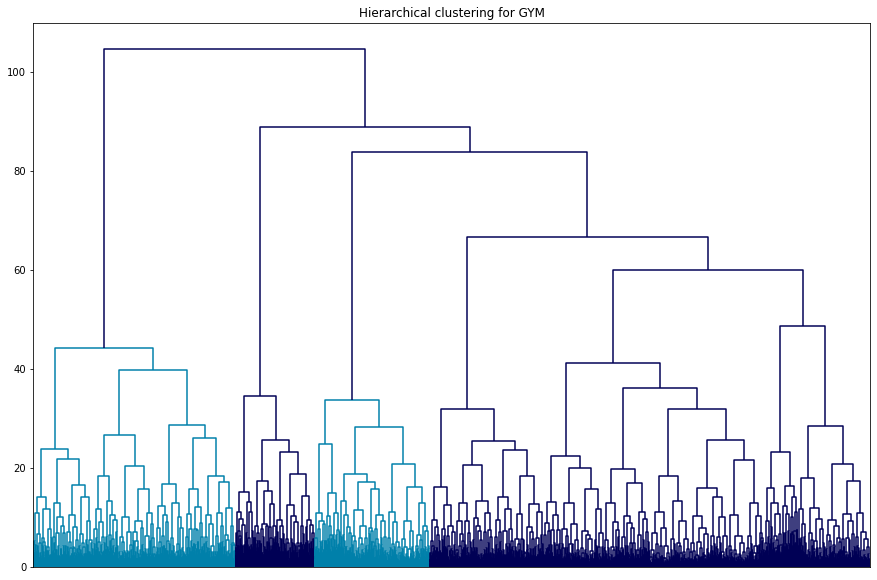

In [18]:
X = gym_data.drop(columns='churn')
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))
plt.gca().axes.get_xaxis().set_visible(False)
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show() 

Above, I standardized the data and plotted a dendrogram of paired features for the clusters using the linkage() function.

In [19]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

labels

array([1, 0, 3, ..., 0, 0, 1], dtype=int32)

I defined the k_means model with 5 clusters and predicted the clusters for observations using the standardized data in the variable "labels". Next, I will store the cluster labels as a column in the dataframe and group the data by the "cluster" column. 

In [20]:
gym_data['cluster'] = labels
gym_data.groupby('cluster', as_index=False).mean()

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [26]:
fig = px.bar(gym_data.groupby('cluster', as_index=False).mean().sort_values(by='cluster', ascending=False),
             y='churn', x='cluster', color_discrete_sequence=(px.colors.sequential.Blues_r, 5),
             title='Mean Churn Values per Cluster')
fig.update_layout(legend=dict(title='Cluster Number'))
fig.show()

Examining the mean churn rate per cluster, we can see the following: 
 - Cluster 0 has the lowest churn rate at 2%;
 - Cluster 4 has the second lowest churn rate at 6%;
 - Clusters 1, 2 and 3 have the highest churn rates at 26%, 44% and 51%, respectively. 

In [22]:
non_bi=['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'lifetime', 'age', 'month_to_end_contract']
for f in non_bi:
    fig = px.bar(gym_data.groupby('cluster', as_index=False).mean(), 
             x='cluster', y=f, color_discrete_sequence=(px.colors.sequential.Blues_r, 6), barmode='group')
    fig.update_layout(width=700, height=400,title='Mean of "{}"'.format(f),
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Average of "{}"'.format(f),
        titlefont_size=12,
        tickfont_size=12), xaxis=dict(
        title="Cluster Number",
        titlefont_size=12,
        tickfont_size=12), legend=dict(title='Cluster Number'))
    fig.show()
    
    fig = px.histogram(gym_data, 
             x=f, histfunc="count", color="cluster", color_discrete_sequence=(px.colors.sequential.YlGnBu_r))
    fig.update_layout(width=750, height=400,title='"{}" per Cluster'.format(f),
                      xaxis_tickfont_size=12,
                      yaxis=dict(
    title='Count of "{}"'.format(f),
    titlefont_size=12,
    tickfont_size=12), xaxis=dict(
    title="{}".format(f),
    titlefont_size=12,
    tickfont_size=12), legend=dict(title='Cluster Number'))
    fig.show()

Above, I examined the means and distribution across clusters per none binary feature: 
 - Cluster 0 - has the second highest mean of "avg_additional_charges_total" and of "avg_class_frequency" both overall and for the current month. Same goes for "lifetime". However, it has, by far, the highest "month_to_end_contract" mean of all clusters. 
 - Cluster 1 - has the third highest mean of "avg_additional_charges_total" and "lifetime", as well as the means of frequency of attendance. This cluster has the 2nd highest "month_to_end_contract" mean.
 - Cluster 2 - has the fourth highest mean of "avg_additional_charges_total" and of attendance. It also has the second lowest "lifetime" mean, same for months till the end of contract. 
 - Cluster 3 - has the lowest mean of practically all features except for age. 
 - Cluster 4 - has the highest mean of "avg_additional_charges_total", "lifetime" and, by far, the highest avg_class_frequency mean of all clusters. However it has a low "month_to_end_contract" mean - third highest at 2.45 while Cluster 0's is the highest at 9.95 - a significant difference. 
 
the "age" feature is insignificant.

In [23]:
bi=gym_data.drop(columns=['avg_additional_charges_total', 'avg_class_frequency_total', 
                             'avg_class_frequency_current_month', 'churn', 'cluster', 'lifetime', 'age', 'month_to_end_contract']).columns
for f in bi:
    fig = px.bar(gym_data.groupby('cluster', as_index=False).mean(), 
             x='cluster', y=f, color_discrete_sequence=(px.colors.sequential.Blues_r, 6), barmode='group')
    fig.update_layout(width=700, height=400,title='Mean of "{}"'.format(f),
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Average of "{}"'.format(f),
        titlefont_size=12,
        tickfont_size=12), xaxis=dict(
        title="Cluster Number",
        titlefont_size=12,
        tickfont_size=12), legend=dict(title='Cluster Number'))
    fig.show() 
    
    fig = px.histogram(gym_data, 
             x=f, histfunc="count", color="cluster", color_discrete_sequence=(px.colors.sequential.YlGnBu_r))
    fig.update_layout(width=750, height=400,title='"{}" per Cluster'.format(f),
                      xaxis_tickfont_size=12,
                      yaxis=dict(
    title='Count of "{}"'.format(f),
    titlefont_size=12,
    tickfont_size=12), xaxis=dict(
    title="{}".format(f),
    titlefont_size=12,
    tickfont_size=12), legend=dict(title='Cluster Number'))
    fig.show()


Next, I examined the means and distribution across clusters per binary feature (and contract period): 
 - Cluster 0 - Has the highest means of "partner", "promo_friends", "contract_period" and "group_visits".
 - Cluster 1 - Has the second highest "promo_friends" and "contract_period" means.
 - Cluster 2 - All of cluster 2 do not live close to the gym, it has the third highest "partner" mean and the lowest "promo_friends" and "group_visits" means. Its "contract_period" mean is the second lowest. 
 - Cluster 3 - All of cluster 3 live close to the gym and it has the lowest "partner" and "contract_period" means. 
 - Cluster 4 - Has the second lowest "partner" and "promo_friends" means. However, it has the second highest "group_visits" mean. 
 
the "gender" feature is insignificant and Cluster 1 has no customers who left a phone number, otherwise this feature is also insignificant. 

### Conclusions 

Clusters 0 and 4 have the lowest churn rates. These Clusters' characteristics are: consistency and loyalty. They frequently attend classes, both overall and recently, alone and group sessions. They invest additional funds which can add to their commitment. 

However, these two Clusters differ on contract periods (and therefore on the months left till the end of their contract) - members of Cluster 4 usually purchase short period contracts while Cluster 0's is more diverse and they have by far the highest mean at more than 10. 

Also, Cluster 0 has significant ties to the gym through their employer who is a partner company of the gym and friends who also attend it, on these features Cluster 4 is on the other end of the spectrum. This means that the contract period, discount and friends is less significant to retain customers (even if it is an incentive).   

## Overall Summary

**Initial Exploration and Preprocessing of the Data**

In these sections I surmised that it is more likely than not that there are no missing values in the data and the data types are correct. 

I also noted that from reviewing the means and the STD's of the values of the dataframe's columns, there aren't any notable anomalies or outliers in the data. 

Finally, I turned all the column names to lower case, for easier and consistent use.

**Exploratory Data Analysis**

I created a table of the means of two groups of customers, those how churned and those who stayed, per feature and concluded the following:
 - There is no notable affect of a customer's gender, or whether a customer provided a phone number, on the fact he or she churned or not;
 - Customer leaving near the gym are more likely to stay, but the difference is insignificant; 
 - If the customer is an employee of a partner company, he or she is more likely to stay - same for customers who joined via a person they know;
 - Commitment breeds staying - customers who frequently attend classes, are more likely to stay (more so with group sessions) - As do customers who invest additional charges; 
 - Customers who are slightly older are more likely to stay; 
 - Customers tend not to churn the further they are from the end of their contract and the longer they are customers. 
 
Scanning the percentage of customers who churned vs. those who stayed in each feature, I noticed similar trends to those noted above:
 - Customers who live near the location of the gym have a high stay percentage;
 - Employees of partner companies also have a higher stay percentage;
 - Most customers didn't become customers via someone they knew, but if they did - they are more likely to stay;
 - Most customers have short term contracts but, the longer the contract period the better;
 - Most customers don't attend group sessions, but if they do - there's a higher percentage of them staying;
 - Older customers have a higher stay percentage than younger ones;
 - Customers who invest additional funds in their membership have a high stay percentage;
 - The more months customers have left, the higher the stay percentage, as do the longer the are customers - loyalty plays its part;
 - Customers who are active participants have higher stay percentage. 

In regards with the target feature, whether customers churn or stay, the highest correlation was with the following features:
 - lifetime;
 - avg_class_frequency_current_month;
 - age;
 - contract_period;
 - month_to_end_contract.
 
There was virtually no correlation between whether customers churn or not and their gender, phone number and group sessions.
 
Recent activity has more correlation with customer churn than with overall activity, and the correlation was not strong in regards to location, customers who are employees of partner companies or if they joined via someone they know or their additional charges. 

**Building s Model to Predict Customer Churn**

In this section I selected four models (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and GradientBoostingClassifier) and ran a loop that takes each model, trains it and uses the trained models to make forecasts and predictions.

Overall, all metrics are above 80% (except for precision in the decisiontreeclassifier model) - that means that the models made the right predictions. Accuracy was 90% and higher, Precision and Recall who aim at avoiding opposing risks were 79%-88% and F1 who balances them out was 80%-86%.

However, one model stood out, GradientBoostingClassifier, with the highest metrics of all four models. Thus, I chose it as the final model. I trained it and created a new dataframe with feature names and importance, then I joined the dataframe with a dataframe with only the features' names. 

I compared the features in the importances list with the results of the previous section. In the correlation matrix lifetime, avg_class_frequency_current_month, age, contract_period and month_to_end_contract had the highest correlation with the feature target - churn. 

In the importances list, using the best performing model (GradientBoostingClassifier), it was clear that four of these features were in top 5 importances with avg_class_frequency_total in third. Lifetime was by far the most important feature with the customer's attendance in the previous month in second place.

**User Clusters**

In this section I standardized the data and plotted a dendrogram of paired features for the clusters using the linkage() function. Then, I defined the k_means model with 5 clusters and predicted the clusters for observations using the standardized data in the variable "labels" and added it as a column in the dataframe. 

Examining the 5 Clusters I surmised the following:
 - Cluster 0 has the lowest churn rate at 2%;
 - Cluster 4 has the second lowest churn rate at 6%;
 - Clusters 1, 2 and 3 have the highest churn rates at 26%, 44% and 51%, respectively. 
 - Cluster 0 - has the second highest mean of "avg_additional_charges_total" and of "avg_class_frequency" both overall and for the current month. Same goes for "lifetime". However, it has, by far, the highest "month_to_end_contract" mean of all clusters. 
 - Cluster 1 - has the third highest mean of "avg_additional_charges_total" and "lifetime", as well as the means of frequency of attendance. This cluster has the 2nd highest "month_to_end_contract" mean.
 - Cluster 2 - has the fourth highest mean of "avg_additional_charges_total" and of attendance. It also has the second lowest "lifetime" mean, same for months till the end of contract. 
 - Cluster 3 - has the lowest mean of practically all features except for age. 
 - Cluster 4 - has the highest mean of "avg_additional_charges_total", "lifetime" and, by far, the highest avg_class_frequency mean of all clusters. However it has a low "month_to_end_contract" mean - third highest at 2.45 while Cluster 0's is the highest at 9.95 - a significant difference. 
 - Cluster 0 - Has the highest means of "partner", "promo_friends", "contract_period" and "group_visits".
 - Cluster 1 - Has the second highest "promo_friends" and "contract_period" means.
 - Cluster 2 - All of cluster 2 do not live close to the gym, it has the third highest "partner" mean and the lowest "promo_friends" and "group_visits" means. Its "contract_period" mean is the second lowest. 
 - Cluster 3 - All of cluster 3 live close to the gym and it has the lowest "partner" and "contract_period" means. 
 - Cluster 4 - Has the second lowest "partner" and "promo_friends" means. However, it has the second highest "group_visits" mean. 
 
The "age", "gender", "phone" and "near_location" features have little to no significance. 
 

## Final Conclusions and Recommendation

What the two Clusters (Clusters 0 and 4) with the lowest churn rate have in common is attendance and consistency. 

They have been the gym's customers for a long time and they show up - they come alone and they come to group classes, a lot and definitely more than the members of the other Clusters.

However, since they differ on the length of the contract they purchase (future long term commitment), whether they are employed by partner companies or used a friend promo (discounts) - it could be helpful to send them a survey to find out what influences their consistent attendance and past commitment. It is also possible that members of Cluster 1 could be incentivized be having more flexible hours for group visits - it is also important to send them a survey. 

Once we better understand their behavior it could be useful for improving the churn rate of members of Cluster 1 and, perhaps, Cluster 2 (if improving Cluster 1's churn rate proves successful). Cluster 1 is the third highest in all the important features of Clusters 0 and 4, so members of this Cluster could churn less once we crack the formula of Clusters 0 and 4. 

It should be noted that features like age, gender, location and even additional charges have little to no bearing on the churn rate. 

Thus, it is possible that a promotional incentive on contract renewal could help or even a competition to promote more consistent attendance (customers who attend x times can win prizes that make working out more enjoyable), group challenges or maybe even hiring a wellness expert or a nutritionist that can give new/returning customers services free of charge for the first month and a discount for the proceeding months.  